# Anemia Color EDA
**Author:** Kyle Uphus • **Repo:** anemia-color-eda • **Notebook:** 02_eda
**Data:** `data/features.csv` (derived from `processed.csv`)

**Goals**
- understand distributions (Hb, log-Hb, color features)
- check correlations among features
- see separation by anemia class (0/1)

## Loading data and libraries

In [10]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import os

FEATURES_PATH = "../data/features.csv"
REPORT_DIR = "../reports/figures"

os.makedirs(REPORT_DIR, exist_ok=True)

df = pd.read_csv(FEATURES_PATH)
df.head()

,number,sex,pct_red_pixel,pct_green_pixel,pct_blue_pixel,hb,anemic,red_ratio,blue_ratio,red_blue_ratio,hb_log
0,1,Male,43.170845,30.945626,25.921971,6.252659,1,0.431543,0.259120,1.665415,1.981368
1,2,Female,43.163481,30.306974,26.759843,8.578865,1,0.430643,0.266984,1.612995,2.259559
2,3,Female,46.269997,27.315656,26.028556,9.640936,1,0.464492,0.261294,1.777663,2.364708
3,4,Female,45.054787,30.469816,24.460797,4.794217,1,0.450614,0.244644,1.841918,1.756860
4,5,Male,45.061884,31.218572,24.071714,8.865329,1,0.449037,0.239872,1.871985,2.289027


In [11]:
df.info()
df.describe(include=[np.number])
print("\nMissing values per column:")
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   number           500 non-null    int64  
 1   sex              500 non-null    object 
 2   pct_red_pixel    500 non-null    float64
 3   pct_green_pixel  500 non-null    float64
 4   pct_blue_pixel   500 non-null    float64
 5   hb               500 non-null    float64
 6   anemic           500 non-null    int64  
 7   red_ratio        500 non-null    float64
 8   blue_ratio       500 non-null    float64
 9   red_blue_ratio   500 non-null    float64
 10  hb_log           500 non-null    float64
dtypes: float64(8), int64(2), object(1)
memory usage: 43.1+ KB

Missing values per column:
number             0
sex                0
pct_red_pixel      0
pct_green_pixel    0
pct_blue_pixel     0
hb                 0
anemic             0
red_ratio          0
blue_ratio         0
red_blue_ratio   

## Visualizing distributions
Spotting skew / outliers and confirming valid ranges

**Checks**
- `hb` likely right-skewed; `hb_log` should be less skewed
- Pixel % in 0-100; ratios in 0-1 (except `red_blue_ratio` > 0)

**Notes**
- `hb` is bimodal with some right skweness. Could be due to male and female having different distributions. 
- Overlayed `hb` and `hb_log` by sex, found that female and male distributions are right-skewed in both versions

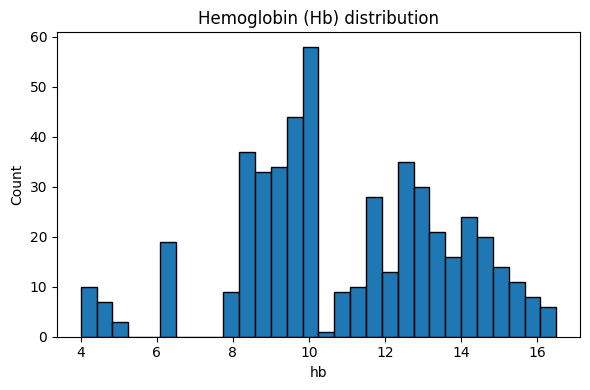

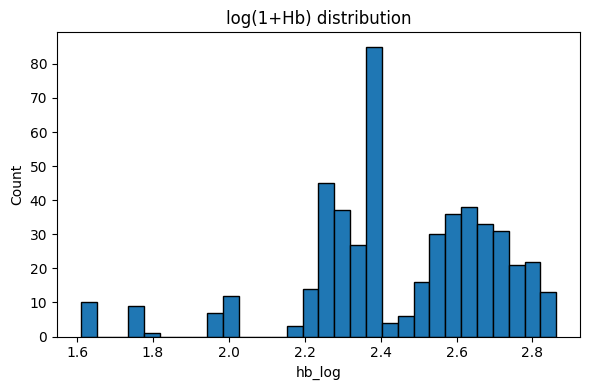

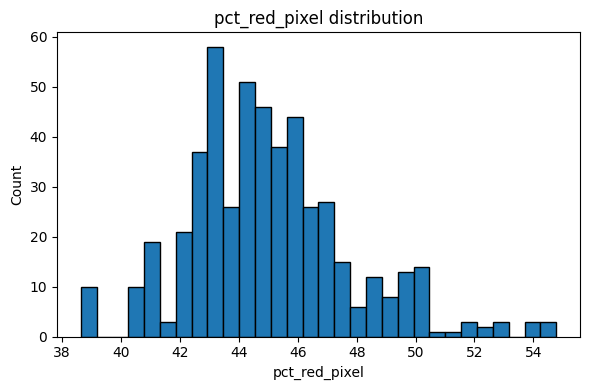

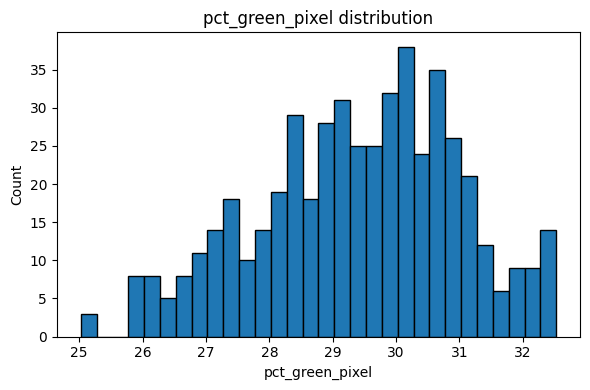

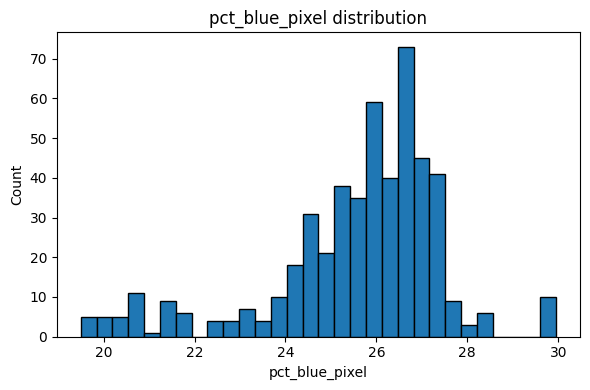

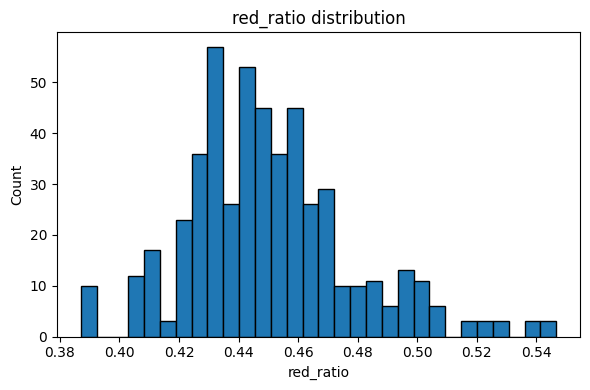

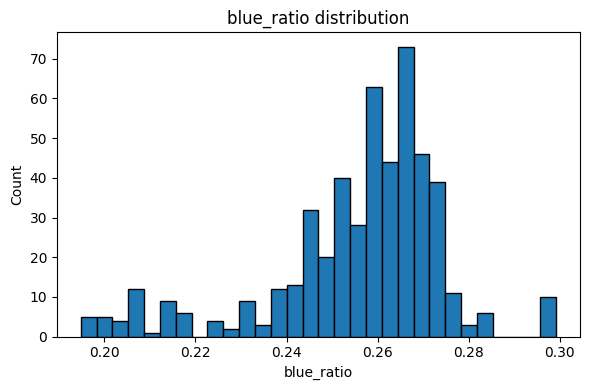

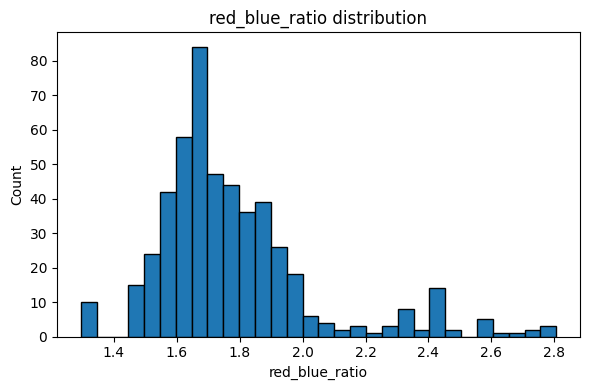

In [12]:
def save_hist(series, title, fname, bins=30):
    plt.figure(figsize=(6,4))
    plt.hist(series.dropna(), bins=bins, edgecolor="black")
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(os.path.join(REPORT_DIR, fname), dpi=200)
    plt.show()

save_hist(df["hb"], "Hemoglobin (Hb) distribution", "hb_hist.png")
save_hist(df["hb_log"], "log(1+Hb) distribution", "hb_log_hist.png")


for col in ["pct_red_pixel", "pct_green_pixel", "pct_blue_pixel", "red_ratio", "blue_ratio", "red_blue_ratio"]:
    save_hist(df[col], f"{col} distribution", f"{col}_hist.png")

### Splitting Hb histograms by sex

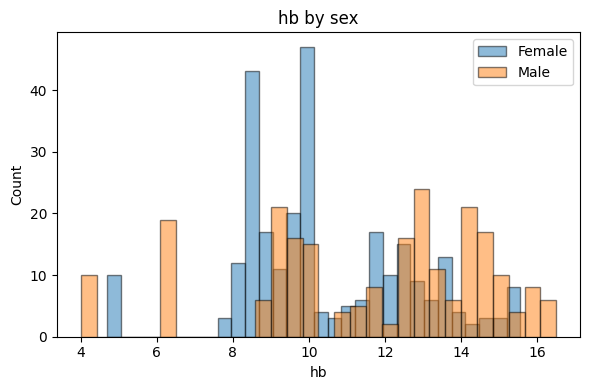

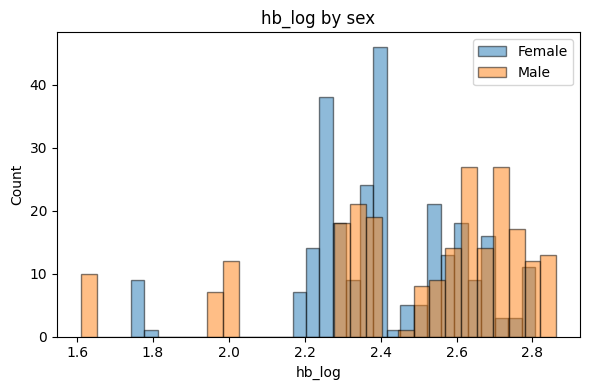

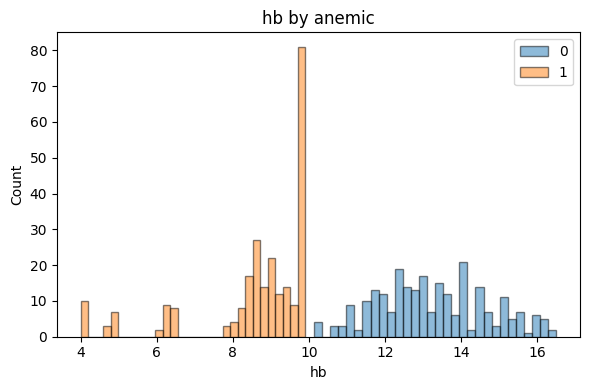

In [13]:
def overlay_hists(col, fname, by, bins=30):
    plt.figure(figsize=(6,4))
    for label, sub in df.groupby(by):
        plt.hist(sub[col].dropna(), bins=bins, alpha=.5, label=str(label), edgecolor="black")
    plt.title(f"{col} by {by}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(REPORT_DIR, fname), dpi=200)
    plt.show()

overlay_hists("hb", "hb_by_sex.png", "sex")
overlay_hists("hb_log", "hb_log_by_sex.png", "sex")
overlay_hists("hb", "hb_by_anemic.png", by="anemic")

## Correlation matrix (numeric features)
Goal: identify features that move with `hb` and `anemic`

**What to look for**
- Strongest positive/negative correlations with `hb`
- Multicollinearity (features that are basically the same information)

**Observations:**
-  Strong negative relationship between Hb and anemia -> Lower Hb means more likely to be anemic
- Negative relationship between green pixel % and Hb
- Moderate positive relationship between red pixel % / red pixel ratio and Hb

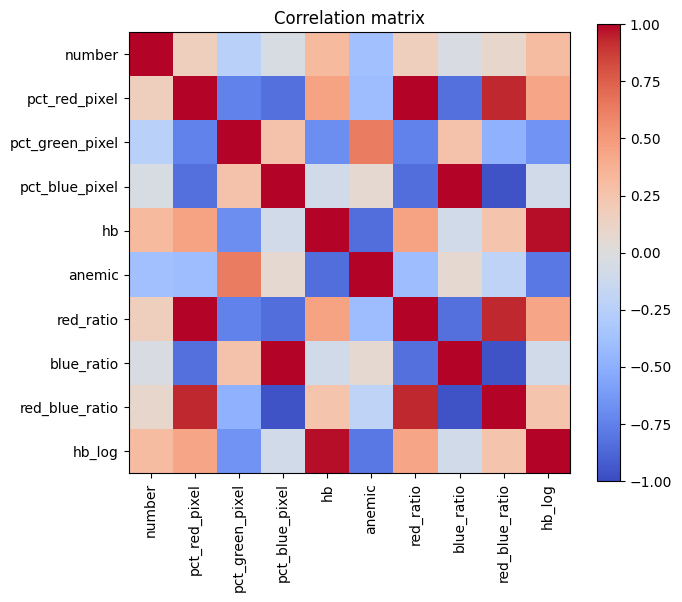

hb                 1.000000
hb_log             0.983497
red_ratio          0.446813
pct_red_pixel      0.446670
number             0.317982
red_blue_ratio     0.243069
blue_ratio        -0.083277
pct_blue_pixel    -0.084008
pct_green_pixel   -0.684738
anemic            -0.839851
Name: hb, dtype: float64

In [14]:
num = df.select_dtypes(include=[np.number])
corr = num.corr(numeric_only=True)

plt.figure(figsize=(7,6))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation matrix")
plt.tight_layout()
plt.savefig(os.path.join(REPORT_DIR, "corr_matrix.png"), dpi=200)
plt.show()

corr["hb"].sort_values(ascending=False).head(10)

## Boxplots by anemia class

/var/folders/d0/7bjghg617tl5sp3h5hk8wtxm0000gn/T/ipykernel_36001/855570384.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[f"{label_col}={v}" for v in sorted(df[label_col].unique())])


FileNotFoundError: [Errno 2] No such file or directory: 'reports/figures/hb_by_anemic.png'

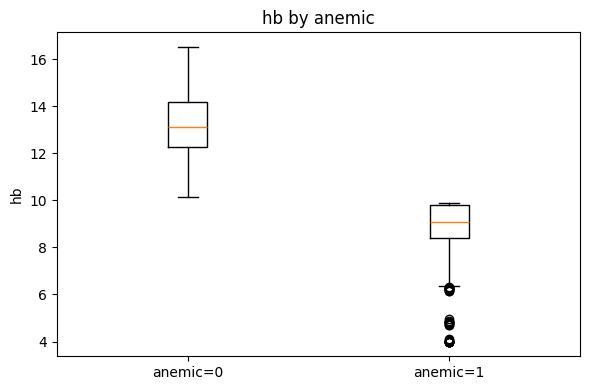

In [15]:
def box_by_label(col, label_col="anemic", fname=None):
    groups = [df.loc[df[label_col]==v, col].dropna() for v in sorted(df[label_col].unique())]
    plt.figure(figsize=(6,4))
    plt.boxplot(groups, labels=[f"{label_col}={v}" for v in sorted(df[label_col].unique())])
    plt.title(f"{col} by {label_col}")
    plt.ylabel(col)
    plt.tight_layout()
    if fname:
        plt.savefig(os.path.join("reports/figures", fname), dpi=200)
    plt.show()
    
for col in ["hb", "pct_red_pixel", "pct_green_pixel", "red_ratio"]:
    box_by_label(col, "anemic", f"{col}_by_anemic.png")

## Feature separation: anemic vs. non-anemic
- Hemoglobin (Hb) shows clear separation, non-anemic falling above ~10 g/dL, anemic falling below (as expected)
- % Red Pixel & Red Ratio are slightly higher in non-anemic group, indicating higher red-intensity levels
- % green pixel is noticably higher in anemic group, consistent with its negative correlation with Hb

## Relationships with Hb (scatter)

**Observations:**
- `pct_red_pixel` vs `hb` (r = 0.45): moderate positive relationship, higher red intensity corresponds with higher hemoglobin level
- `pct_green_pixel` vs `hb` (r = -0.68): strong negative relationship, greener images correspond to lower hemoglobin level
- `red_ratio` vs `hb` (r = 0.45): consistant with %red pixel
- `red_blue_ratio` vs `hb` (r = 0.24): weak positive relationship

*Interpretation*: red- and green-channel features carry clear signal for Hb levels, while blue contributes little

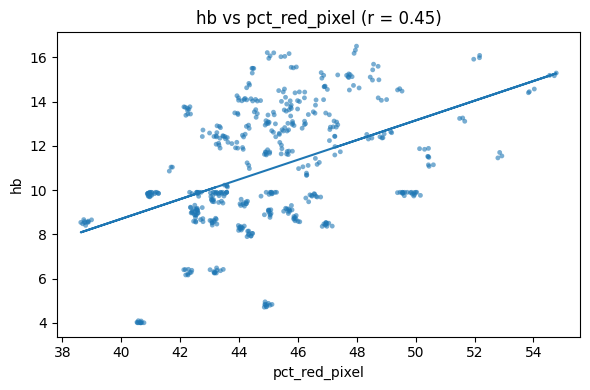

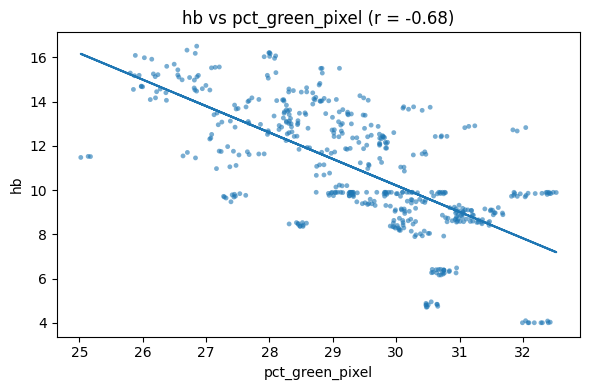

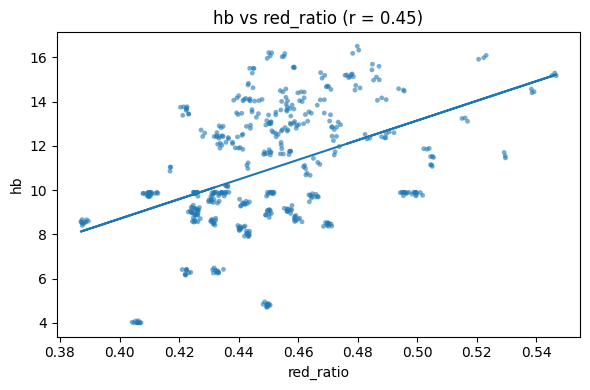

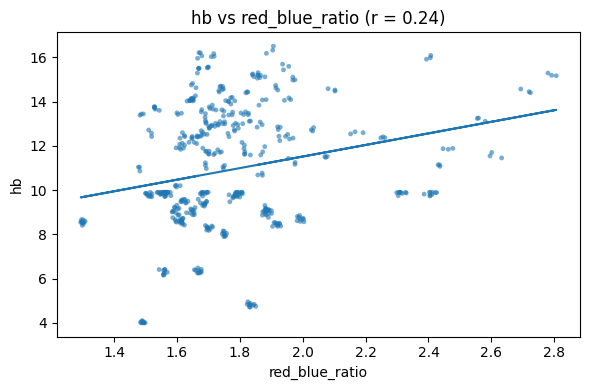

In [ ]:
FIG_DIR = "../reports/figures"
os.makedirs(FIG_DIR, exist_ok=True)

def scatter_with_fit(xcol, ycol, fname, df=df):
    x = df[xcol].values
    y = df[ycol].values
    
    # best-fit line
    m, b = np.polyfit(x, y, 1)
    
    # Pearson r
    r = np.corrcoef(x, y)[0, 1]
    
    plt.figure(figsize=(6,4))
    plt.scatter(x, y, s=12, alpha=0.6, edgecolors="none")
    plt.plot(x, m*x + b)
    plt.xlabel(xcol); plt.ylabel(ycol)
    plt.title(f"{ycol} vs {xcol} (r = {r:.2f})")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, fname), dpi=200)
    plt.show()

# image features vs Hb
scatter_with_fit("pct_red_pixel", "hb", "hb_vs_pct_red.png")
scatter_with_fit("pct_green_pixel", "hb", "hb_vs_pct_green.png")
scatter_with_fit("red_ratio", "hb", "hb_vs_red_ratio.png")
scatter_with_fit("red_blue_ratio", "hb", "hb_vs_red_blue_ratio.png")

## Summarize by Anemia Class

In [ ]:
summary = (
    df.groupby("anemic")[[
        "hb", "hb_log", "red_ratio", "red_blue_ratio", "pct_red_pixel", 
        "pct_green_pixel", "pct_blue_pixel"
    ]]
        .agg(["mean", "std", "median", "min", "max"])
)
summary.to_csv("../reports/anemia_group_summary.csv", index=True)
summary


def cohens_d(col):
    a = df.loc[df["anemic"]==1, col].dropna()
    b = df.loc[df["anemic"]==0, col].dropna()
    s = np.sqrt(((a.size-1)*a.var(ddof=1) + (b.size-1)*b.var(ddof=1)) / (a.size+b.size-2))
    return (a.mean()-b.mean())/s

for c in ["hb","pct_green_pixel","pct_red_pixel","red_ratio"]:
    print(c, round(cohens_d(c),3))

hb -3.088
pct_green_pixel 1.623
pct_red_pixel -0.875
red_ratio -0.876


In [ ]:
anemic_counts = df["anemic"].value_counts()

anemic_percentage = (anemic_counts / len(df)) * 100

print(anemic_percentage)

anemic
1    50.0
0    50.0
Name: count, dtype: float64


## Summary Statistics by Anemia Class
- Non-anemic mean Hb = 13.26, anemic = 8.62 
- % Green Pixel higher in anemic group; % Red Pixel higher in non-anemic group

## Effect Sizes (Cohen's *d*) - Anemic vs. Non-Anemic
| Feature | d | Interpretation | Direction |
|----------|------:|----------------|-------------|
| Hb | −3.09 | Very large | Hb much lower in anemic group |
| % Green Pixel | +1.62 | Large | Higher green intensity in anemic group |
| % Red Pixel | −0.88 | Large | Higher red intensity in non-anemic group |
| Red Ratio | −0.88 | Large | Mirrors % Red Pixel trend |

**Interpretation**
Hemoglobin shows the largest class separation, confirming it's the primary driver of the anemia label. Color features (red and green channels) also have strong but opposite effects, indicating measurable color shifts associated with anemia. 

## Key Findings (EDA)

**Signal strength**
- **Hb** shows the strongest separation betwen classes (Cohen's *d* ≈ **-3.09**; anemic << non-anemic).
- **% Green Pixel** is substantially higher in the anemic group (*d* ≈ **+1.62**), while **% Red Pixel** and **Red Ratio** are higher in the non-anemic group (*d* ≈ **-0.88** each).

**Correlations with Hb**
- % Red Pixel (r ≈ **+0.45**) and Red Ratio (r ≈ **+0.45) rises with Hb.
- % Green Pixel (r ≈ **0.68) falls as Hb increases
- Blue channel features are weakly related to Hb.

**Distribution & class balance**
- Hb distributinos are bimodal overall (driven by sex), but **within-sex** separation by anemia status remains strong
- Class balance: **50% anemic**, **50% non-anemic**

**Takeaway**
- Hb is the primary driver of the label, with color features adding consistent, directional signals. This justifies a simple clinical rule baseline (sex-aware Hb thresholds) before any ML.

## Plots Featured in README

| Plot | Description |
|------|--------------|
| ![Hb by Sex](../reports/figures/hb_by_sex.png) | Hemoglobin levels are clearly separated by sex, with males showing higher average Hb and a right-shifted distribuution. This supports known biological variation and explains the bimodal shape of the overall Hb distribution. |
| ![Hb by Anemia](../reports/figures/hb_by_anemic.png) | Anemic and non-anemic groups display a distinct separation in Hb levls, confirming the expected physiological threshold around 10 g/dL. |
| ![Hb vs Red Pixel](../reports/figures/hb_vs_pct_red.png) | Hb levels show a moderate positive correlation with red pixel intensity (r ≈ 0.45), indicating that higher redness in images corresponds to higher hemoglobin concentration. |
| ![Hb vs Green Pixel](../reports/figures/hb_vs_pct_green.png) | Hb levels exhibit a strong negative correlation with green pixel intensity (r ≈ −0.68), indicating that higher green intensity in images corresponds to lower hemoglobin concentration.  |
| ![Correlation Matrix](../reports/figures/corr_matrix.png) | Confirms Hb–color feature relationships and highlights the predictive potential of red and green intensity metrics. |